In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.io as spio
import tensorflow as tf
%matplotlib inline

from six.moves import urllib

In [2]:
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train = X_train/255.0
X_test = X_test/255.0

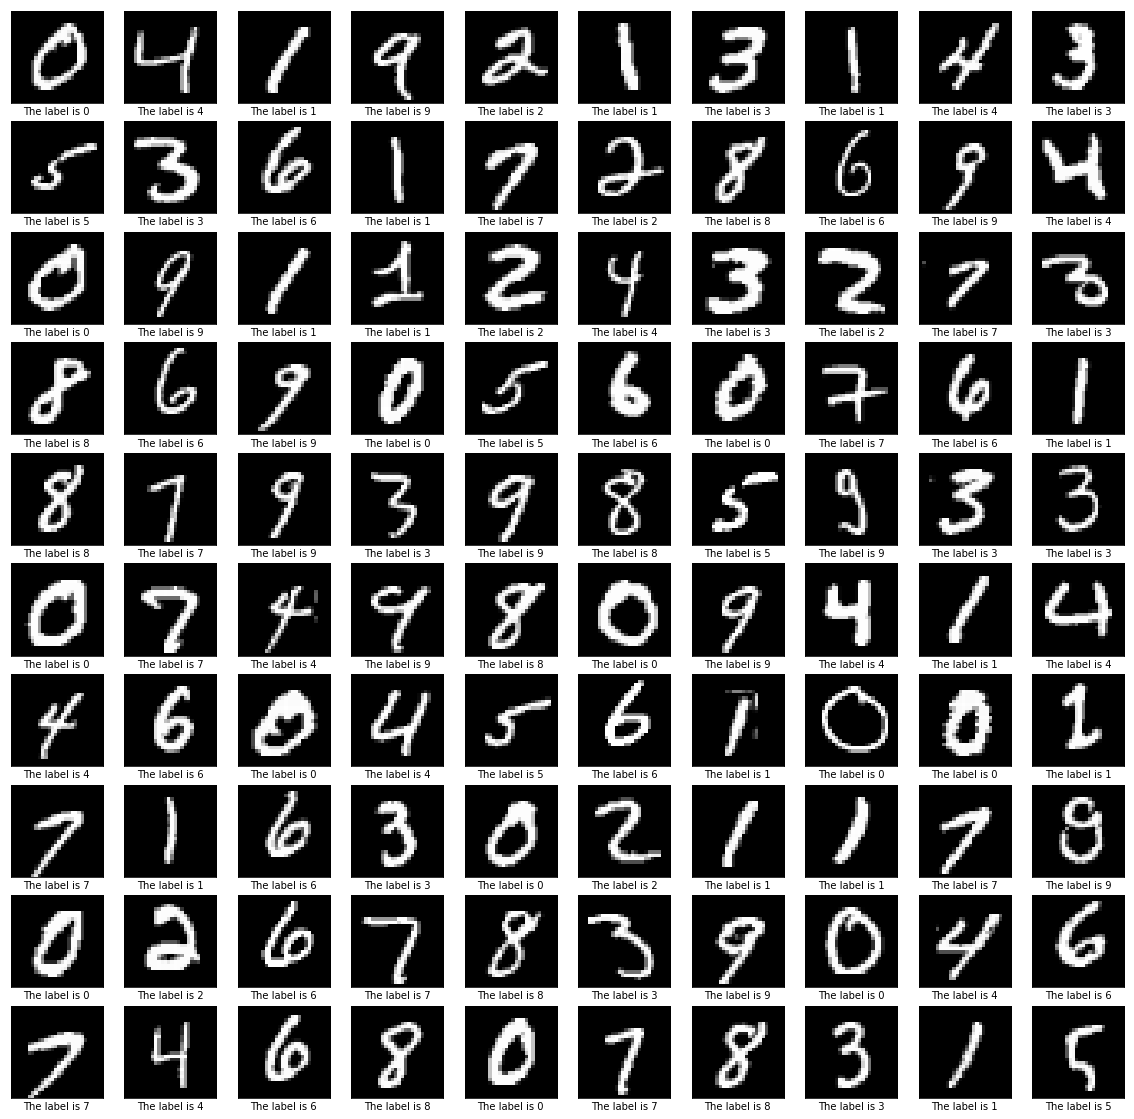

In [4]:
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("The label is {}".format(y_train[i+1]))
    plt.imshow(X_train[i+1,:,:],cmap='gray')

In [5]:
height = 28
width = 28
channels = 1
n_inputs = height * width

In [7]:
conv1_feature_maps = 32
conv1_kernel_size = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_feature_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_feature_maps = conv2_feature_maps

n_dense1 = 128
n_dense2 = 64
n_output = 10

In [8]:
def build_cnn(features):
    X = tf.reshape(features['images'],shape=[-1,height,width,channels])
    conv1 = tf.layers.conv2d(X,filters=conv1_feature_maps, kernel_size=conv1_kernel_size, strides = conv1_stride, padding=conv1_pad, activation=tf.nn.relu,name='conv1')
    conv2 = tf.layers.conv2d(conv1, filters=conv2_feature_maps, kernel_size=conv2_kernel_size, strides=conv2_stride,padding=conv2_pad,activation=tf.nn.relu,name='conv2')
    pool3 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    pool3_flat = tf.reshape(pool3,shape=(-1,pool3_feature_maps*7*7))
    dense1 = tf.layers.dense(pool3_flat,n_dense1,activation=tf.nn.relu,name='dense1')
    logits = tf.layers.dense(dense1,n_output,name='outputs')
    return logits

In [14]:
def cnn_model_fn(features,labels,mode):
    logits = build_cnn(features)
    predicted_class = tf.argmax(logits,axis=1)
    #Prediction Mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode,predicted_class)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=tf.cast(labels,dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss,global_step=tf.train.get_global_step())
    
    #Training Mode
    if mode==tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode,loss=loss,train_op=train_op)
    
    #Evaluation Mode
    accuracy = tf.metrics.accuracy(labels=labels,predictions=predicted_class)
    
    return tf.estimator.EstimatorSpec(mode=mode,predictions = predicted_class,train_op=train_op,loss=loss,eval_metric_ops={'accuracy':accuracy})

In [15]:
num_steps = 2000
batch_size = 100

In [16]:
model = tf.estimator.Estimator(cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_device_fn': None, '_task_type': 'worker', '_model_dir': 'C:\\Users\\Lolly\\AppData\\Local\\Temp\\tmpwxc5apke', '_log_step_count_steps': 100, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000183C9C6CD30>, '_protocol': None, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 1, '_train_distribute': None, '_master': '', '_evaluation_master': '', '_eval_distribute': None, '_experimental_distribute': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_service': None, '_num_ps_replicas': 0}


In [17]:
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images':X_train},y=y_train,batch_size=batch_size,num_epochs=None,shuffle=True)

In [18]:
model.train(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Lolly\AppData\Local\Temp\tmpwxc5apke\model.ckpt.
INFO:tensorflow:loss = 2.3141491716298406, step = 1
INFO:tensorflow:global_step/sec: 3.19254
INFO:tensorflow:loss = 0.2284437967945709, step = 101 (31.318 sec)
INFO:tensorflow:global_step/sec: 2.66849
INFO:tensorflow:loss = 0.14038760046180218, step = 201 (37.484 sec)
INFO:tensorflow:global_step/sec: 3.29138
INFO:tensorflow:loss = 0.062765831739191, step = 301 (30.372 sec)
INFO:tensorflow:global_step/sec: 3.35606
INFO:tensorflow:loss = 0.10161350481687735, step = 401 (29.867 sec)
INFO:tensorflow:global_step/sec: 3.36407
INFO:tensorflow:loss = 0.06857212951709175, step =

KeyboardInterrupt: 

In [19]:
input_fn = tf.estimator.inputs.numpy_input_fn(x={'images':X_test},y=y_test,batch_size=batch_size,shuffle=False)

In [20]:
e = model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-15-21:29:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Lolly\AppData\Local\Temp\tmpwxc5apke\model.ckpt-1974
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-15-21:29:26
INFO:tensorflow:Saving dict for global step 1974: accuracy = 0.9881, global_step = 1974, loss = 0.034188334
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1974: C:\Users\Lolly\AppData\Local\Temp\tmpwxc5apke\model.ckpt-1974


In [22]:
print("Testing Accuracy: {}".format(e['accuracy']))

Testing Accuracy: 0.988099992275238
